<a href="https://colab.research.google.com/github/HarisGunawanRomadon/DL-tugas-per-3-VAE/blob/main/pert_3_Haris_Gunawan_Romadon_41236718.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TUGAS DEEP LEARNING LANJUT 3 VAE


---


Nama : Haris Gunawan Romadon

NIM : 41236718

Kelas : TI2023-KIP-P2

Prodi : Teknik Informatika

In [2]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [3]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [6]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - kl_loss: 4.0352 - reconstruction_loss: 396.6440 - total_loss: 400.6792 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9635 - reconstruction_loss: 266.3853 - total_loss: 272.3488 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9722 - reconstruction_loss: 261.7620 - total_loss: 267.7343 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.0368 - reconstruction_loss: 259.8304 - total_loss: 265.8672 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.1176 - reconstruction_loss: 257.8331 - total_loss: 263.95

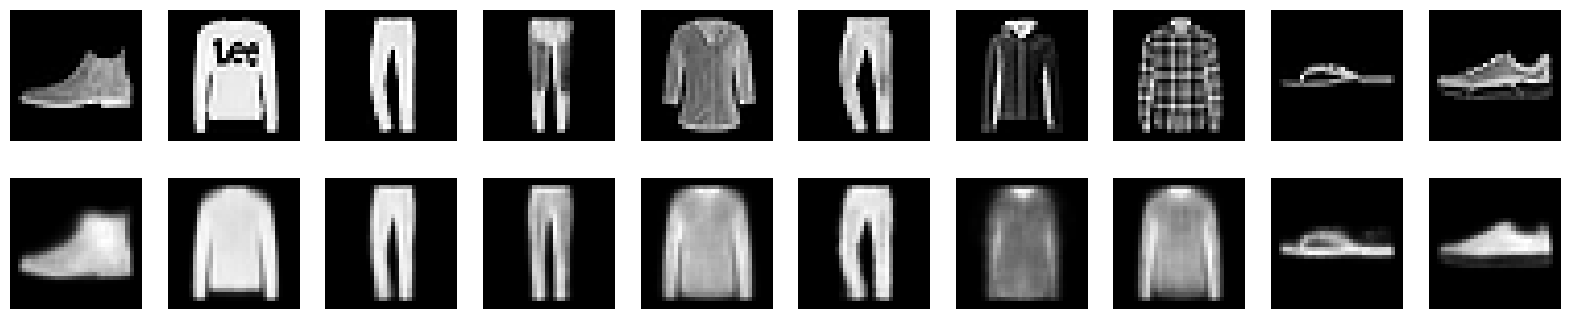

In [7]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


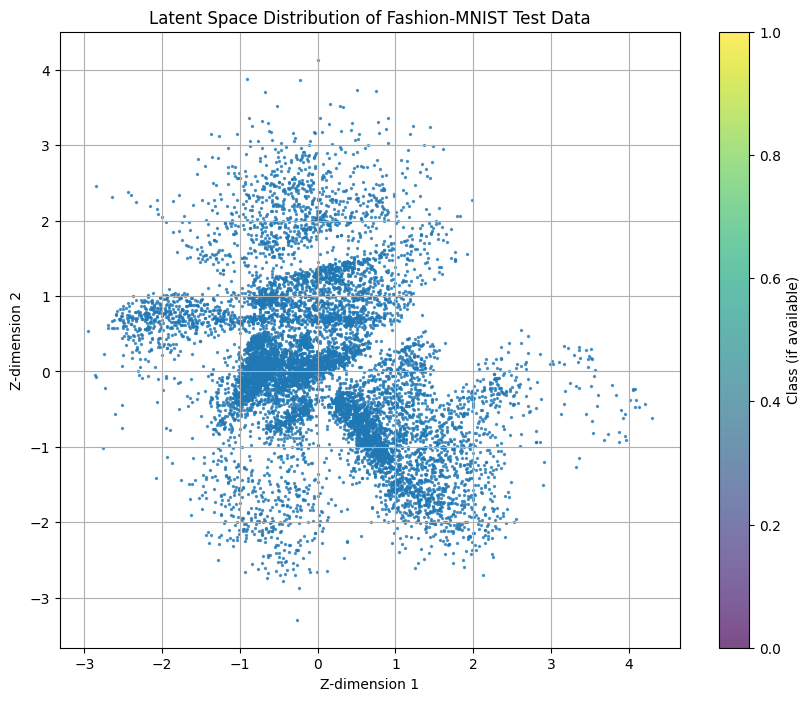

In [8]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test) # Correctly calculate z_means

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [9]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [10]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 0.99910665 -0.8621115 ]
 [-0.7796579  -0.05812747]
 [-1.0937209   2.3494241 ]
 [ 0.02814193  1.9876329 ]
 [-0.28180146 -0.16675922]]


## Visualize Latent Space Distribution by Class



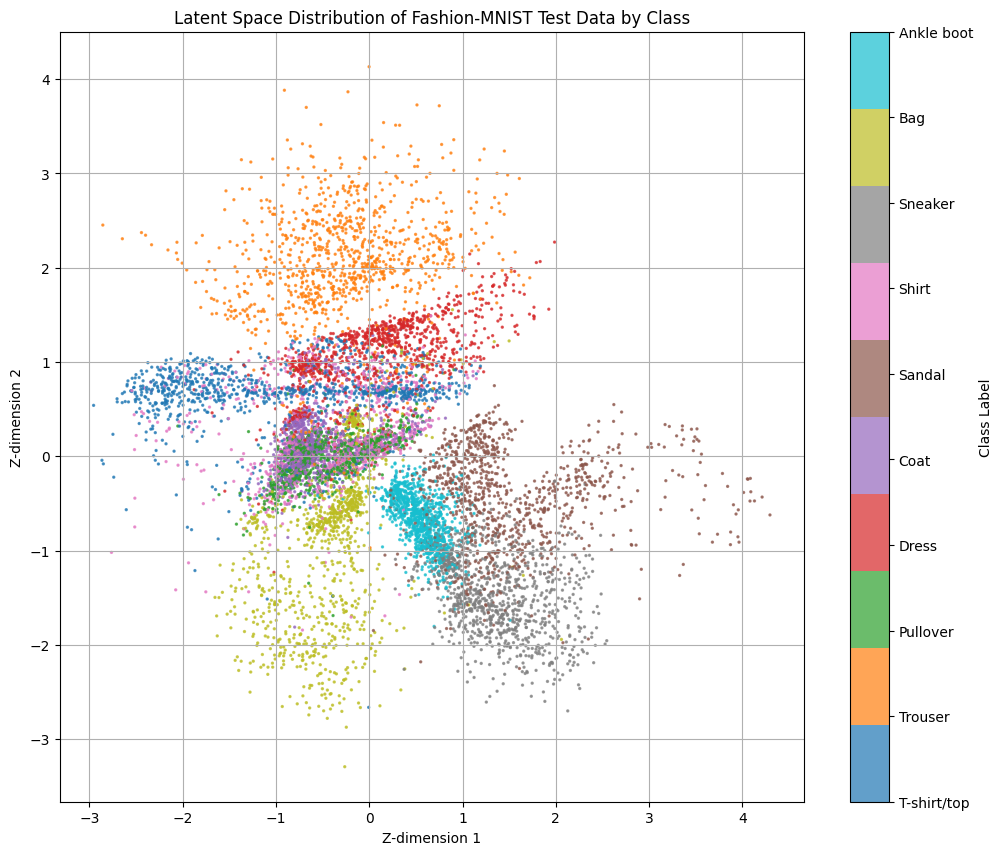

In [11]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


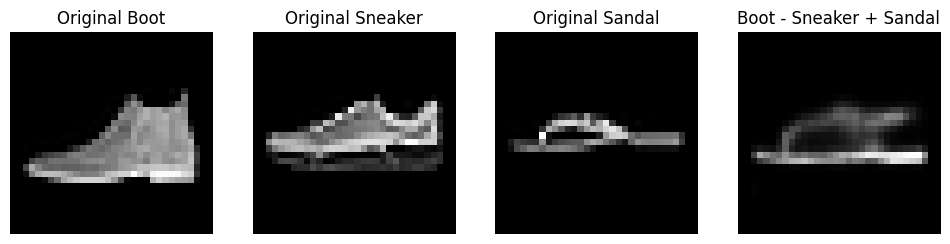

In [12]:
# -------------------------------
# Latent Space Arithmetic (Contoh pada Fashion-MNIST)
# -------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Pilih indeks sampel dari kelas tertentu
idx_boot = np.where(y_test == 9)[0][0]  # Ankle boot
idx_sneaker = np.where(y_test == 7)[0][0]  # Sneaker
idx_sandal = np.where(y_test == 5)[0][0]  # Sandal

# Encode sampel-sampel tersebut
z_mean_boot, _, _ = vae.encoder.predict(np.expand_dims(x_test[idx_boot], 0))
z_mean_sneaker, _, _ = vae.encoder.predict(np.expand_dims(x_test[idx_sneaker], 0))
z_mean_sandal, _, _ = vae.encoder.predict(np.expand_dims(x_test[idx_sandal], 0))

# Lakukan arithmetic: boot - sneaker + sandal
z_arithmetic = z_mean_boot - z_mean_sneaker + z_mean_sandal

# Decode hasil arithmetic
reconstructed_arithmetic = vae.decoder.predict(z_arithmetic)

# Visualisasi
plt.figure(figsize=(12, 4))
# Original Ankle Boot
plt.subplot(1, 4, 1)
plt.imshow(x_test[idx_boot].squeeze(), cmap='gray')
plt.title('Original Boot')
plt.axis('off')

# Original Sneaker
plt.subplot(1, 4, 2)
plt.imshow(x_test[idx_sneaker].squeeze(), cmap='gray')
plt.title('Original Sneaker')
plt.axis('off')

# Original Sandal
plt.subplot(1, 4, 3)
plt.imshow(x_test[idx_sandal].squeeze(), cmap='gray')
plt.title('Original Sandal')
plt.axis('off')

# Hasil Arithmetic
plt.subplot(1, 4, 4)
plt.imshow(reconstructed_arithmetic.squeeze(), cmap='gray')
plt.title('Boot - Sneaker + Sandal')
plt.axis('off')

plt.show()

Model: "ae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_encoder_input (InputLayer)   │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_ae (Dense)                    │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.2830 - val_loss: 0.2571
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2539 - val_loss: 0.2533
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2511 - val_loss: 0.2510
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2485 - val_loss: 0.2500
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2479 - val_loss: 0.2491
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2470 - val_loss: 0.2488
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2461 - val_loss: 0.2484
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2459 - val_loss: 0.2483
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2458 - val_loss: 0.2482
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2446 - val_loss: 0.2474
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2443 - val_loss: 0.2471
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━

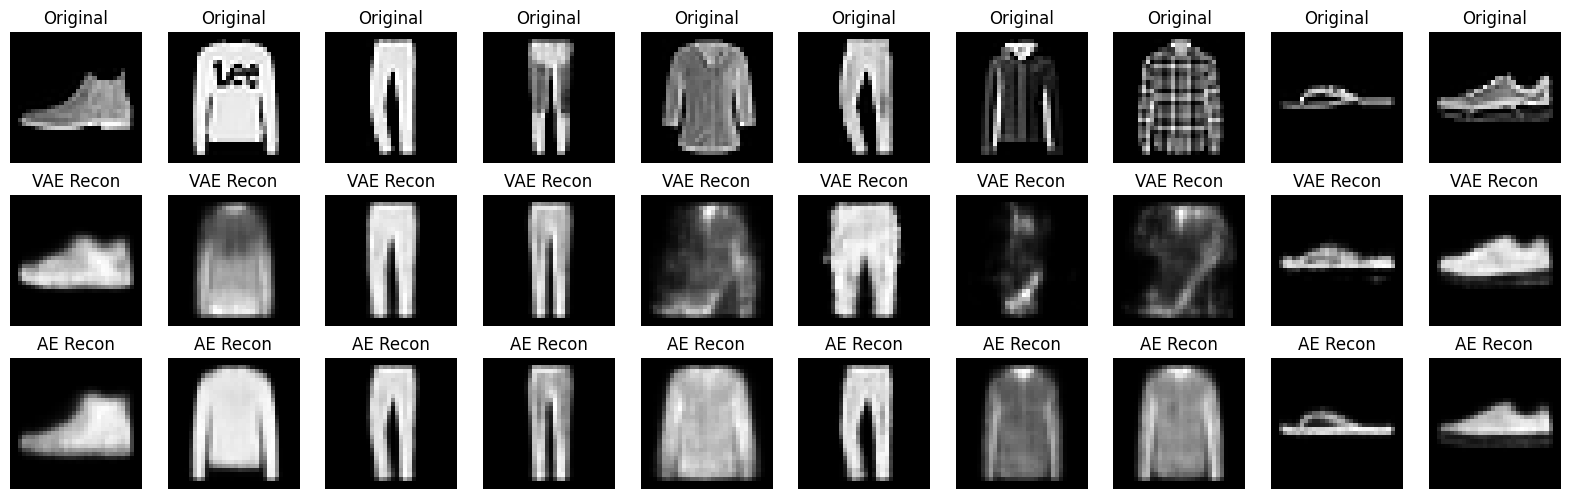

In [13]:
# -------------------------------
# Perbandingan Rekonstruksi antara VAE dan Autoencoder Biasa
# -------------------------------
# Bangun Autoencoder sederhana (AE) dengan arsitektur mirip, tapi tanpa variational

# Encoder AE (mirip tapi tanpa z_log_var dan sampling)
ae_encoder_input = layers.Input(shape=(32, 32, 1), name="ae_encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ae_encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening_ae = x.shape[1:]
x = layers.Flatten()(x)
z_ae = layers.Dense(latent_dim, name="z_ae")(x)  # Hanya mean, tanpa var
ae_encoder = models.Model(ae_encoder_input, z_ae, name="ae_encoder")
ae_encoder.summary()

# Decoder AE (sama dengan VAE decoder)
ae_decoder = decoder  # Reuse decoder dari VAE untuk fairness

# Bangun AE model
class AE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

ae = AE(ae_encoder, ae_decoder)
ae.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')

# Latih AE
ae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

# Visualisasi perbandingan rekonstruksi
def plot_comparison_reconstructions(vae_model, ae_model, data, n=10):
    # Rekonstruksi VAE
    _, _, vae_reconstructions = vae_model(data[:n])
    # Rekonstruksi AE
    ae_reconstructions = ae_model.predict(data[:n])

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_reconstructions[i].numpy().squeeze(), cmap="gray")
        plt.title("VAE Recon")
        plt.axis("off")

        # Rekonstruksi AE
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_reconstructions[i].squeeze(), cmap="gray")
        plt.title("AE Recon")
        plt.axis("off")
    plt.show()

plot_comparison_reconstructions(vae, ae, x_test)